# GFER antibodies 20181231 - Cox17 - Round II
_Maydan Wienreb_
<img src="https://raw.githubusercontent.com/maydanw/InEasyReach/master/hr-brian-litzinger-one.png" alt="Drawing" style="width: 100%; height: 60px" />

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports

In [2]:
"""
This will enable completion on elements of lists, results of function calls, etc.
However, be warned that enabling this option can be unsafe, because the code is actually evaluated upon hitting TAB
"""
%config IPCompleter.greedy=True

from typing import Dict, Tuple, List

# import numpy
import numpy as np
np.random.seed(0) # Remmeber to reset the seed every time if you expect the second draw to be the same as the first.

#import pandas
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# import graphics
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = [12.0, 8.0]
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'
import seaborn as sns
sns.set_style("whitegrid")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# %load_ext autoreload
# %autoreload 1
# %aimport TestFunctions
## See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html


In [3]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

# Do run in the first time: jupyter nbextension enable --py --sys-prefix widgetsnbextension

Loading BokehJS ...

In [4]:
import types
import sys
print ("Basic packages versions:")
print ("   Python version: %s" % (sys.version))
print ("   Packages:")


try:  
    g=globals().values()
    for i, mod in enumerate(g):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__') and hasattr(mod, '__version__'):
                print ("   %s: %s" % (mod.__name__, mod.__version__))
except: 
    g=globals().values()
    for i, mod in enumerate(g):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__') and hasattr(mod, '__version__'):
                print ("   %s: %s" % (mod.__name__, mod.__version__))

Basic packages versions:
   Python version: 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
   Packages:
   json: 2.0.9
   numpy: 1.15.0
   pandas: 0.23.3
   seaborn: 0.9.0


# General

In [100]:
patients = {"AV": {'age': 6*4, "gender": "M", "color": "cornflowerblue"}, 
            "EV": {"age": 5.5*12*4, "gender": "F", "color": "violet"},
            "HC CM": {"age": 6*12*4, "gender": "F", "color": "green"},
            "AG044": {"age": 15, "gender": "F", "color": "limegreen"},
            "AG015": {"age": 3/7, "gender": "M", "color": "cyan"},
            "HV": {"age": 37*12*4, "gender": "F", "color": "darkviolet"},
            "MV": {"age": 36.5*12*4, "gender": "M", "color": "royalblue"},
            "HC IK": {"age": 32*12*4, "gender": "F", "color": "gray"},
            "HC OZ": {"age": 35*12*4, "gender": "M", "color": "yellow"},
            "HC NA0730":{"age": 53*12*4, "gender": "M", "color": "coral"}}
patients_df = pd.DataFrame(patients).T
patients_df[['age', 'gender', 'color']]


age gender           color
AV               24      M  cornflowerblue
EV              264      F          violet
HC CM           288      F           green
AG044            15      F       limegreen
AG015      0.428571      M            cyan
HV             1776      F      darkviolet
MV             1752      M       royalblue
HC IK          1536      F            gray
HC OZ          1680      M          yellow
HC NA0730      2544      M           coral

In [6]:
from scipy.stats import mannwhitneyu

def compare_results(df, base_key, feature_name, df_grpby_key='Pcol', hyp_alternative="less"):
    df_grp_row = df.groupby(df_grpby_key)
    base_data = df_grp_row[feature_name].get_group(base_key)

    p_values = {}
    for grp_k in df_grp_row[feature_name].groups.keys():
        if grp_k==base_key:
            continue
        p_data = df_grp_row[feature_name].get_group(grp_k)
        stat, p = mannwhitneyu(base_data, p_data, alternative=hyp_alternative)
        p_values[grp_k] = p
    return p_values

In [7]:
def pval_corrected(pvals_raw, method=None):
    '''p-values corrected for multiple testing problem
 
    This uses the default p-value correction of the instance stored in
    ``self.multitest_method`` if method is None.
 
    '''
    import statsmodels.stats.multitest as smt
    if method is None:
        method = 'Bonferroni'
    #TODO: breaks with method=None
    return smt.multipletests(pvals_raw, method=method)[1]

In [8]:
from bokeh.transform import factor_cmap
from bokeh.models import ColumnDataSource, CategoricalColorMapper, LabelSet
from bokeh.palettes import Set3
from bokeh.palettes import d3
from bokeh.models.tools import HoverTool
from bokeh.models import NumeralTickFormatter


def plot_column(df, column_name, agg='50%'):

    TOOLS='pan,wheel_zoom,box_zoom,reset'

    source = ColumnDataSource(df)
    patients_names =  source.data['Pcol'].tolist()
    plot_options = dict(width=750, plot_height=350,tools=TOOLS)
    p = figure(**plot_options, x_range=patients_names)


    # palette = d3['Category10'][len(patients_names)]
    # palette = [patients[pn]['color'] for pn in patients_names]
    # color_map = CategoricalColorMapper(factors=patients_names, palette=palette)
    
    source.data['color'] = [patients[pn]['color'] for pn in patients_names]
    source.data['age'] = [patients[pn]['age']/4/12 for pn in patients_names]
    source.data['gender'] = [patients[pn]['gender'] for pn in patients_names]
    
    cell_count = df["Pcol"].count().to_dict()
    source.data['cell_count'] = [cell_count[pn] for pn in patients_names]

    # renderer = p.vbar(x='Pcol', top='Cox17 IxA_50%', width=0.95, line_color="gray", source=source, color={'field': 'Pcol', 'transform': color_map})
    renderer = p.vbar(x='Pcol', top=f"{column_name}_{agg}", width=0.95, line_color="gray", source=source, color='color')
    
    source.data[f"formatted_{column_name}_{agg}"] = [f"{x:,.4f}" if x<10 else f"{x:,.0f}" for x in source.data[f"{column_name}_{agg}"]]
    labels = LabelSet(x='Pcol', y=f"{column_name}_{agg}", text=f"formatted_{column_name}_{agg}", level='glyph',
        x_offset=-30, y_offset=0, source=source, render_mode='canvas')
    p.add_layout(labels)

    p.add_tools(HoverTool(tooltips= [("Name", "@Pcol"), ("Age", "@age"), ("Gender", "@gender"), ("Cell count", "@cell_count")], renderers=[renderer], mode='mouse'))
    p.yaxis[0].formatter = NumeralTickFormatter(format="0,0.00")

    show(p)

# Cox 17

## Loading Data

In [9]:
data_path = ".\\Data\\20181231 - Cox17 GFER\\cox mito bycell1.xls"

In [10]:
# read the data from the file
df_cox17 = pd.read_excel(data_path, header=1)

# remove redundent column
df_cox17.drop("Target Set",axis=1, inplace=True)

# rename columns
df_cox17.columns = df_cox17.columns.str.replace("TMRE", "Cox17")
df_cox17.rename({"cox total int": "Cox17 total intensity"}, axis="columns", inplace=True)

# extract the positional data 
loc_df = df_cox17.Section.str.extract("(.*) - (.*) \(fld (.*)\).*",expand=True)
loc_df.columns=["Prow","Pcol", "Pfield"]
loc_df.Pcol = loc_df.Pcol.astype(np.int16)
df_cox17 = df_cox17.join(loc_df)
df_cox17.drop("Section",axis=1, inplace=True)

# replace rows with patients names and join patients data
df_cox17.Pcol.replace([2,3,4,5,6,7,8,9,10,11], 
                ["AV", "HC CM", "EV", "AG044", "HV", "AG015", "HC IK", "MV", "HC OZ", "HC NA0730"],
               inplace=True)
df_cox17 = df_cox17.join(patients_df, on='Pcol')

df_cox17.sample(7)

Target  Cox17 AREA  Cox17 POS X  Cox17 POS Y  Cox17 INTENSITY  Cox17 FORM FACTOR  Cox17 COUNT   Cox17 DxA  Cox17 mean area  Cox17 mean intesity  MITOTRECKER AREA  MITO POS Y  MITOTRACKER DxA  MITOTRACKER FORM FACTOR  MITOTRACKER INTENSITY  MITOTRACKER COUNT  MITO POS X  NUCLEAR DXA  NUC CG X  NUC CG Y  NUC FORM FACTOR  NUC MEDIAN DENSITY  NUCLEAR PARIMETER  NUCLEAR WRMI  NUCLEUS MAX CHORD  NUCLEAR AVG DIAMETER  NUCLEAR MED DIAMETER  NUCLEAR AREA  NUCLEAR INTENSITY  CELL INTENSITY      CELL DXA  CELL AREA  CELL FORM FACTOR  CELL FIBER LENGTH  CELL END NODES  CELL PARIEMETER  CELL AVG  DIAMETER  CELL MED DIAMETER  CELL FRMI  CELL LENGTH  CELL CROSSING POINTS  CELL BRANCH NODES Prow   Pcol Pfield       age       color gender
2234      13     203.542    22323.473    11872.502       161676.373              1.028           74  566074.097            2.751             2781.111           634.710    2124.393      2936287.435                    1.039              61134.336                 13    4111.372   598634.548   296.391   164.631            0.928              3966.0             45.051         0.866             16.827                17.385                17.065       149.884           3993.982       13543.933  3.067777e+07   2265.056             0.147            424.083              23          440.329              17.385             17.065      0.987      103.828                     2                 17    F  HC IK     19      1536        gray      F
2198      11     111.859    19213.834    22006.573        99674.761              0.961           48  265010.551            2.330             2369.158           664.391   27712.742      2500071.190                    1.149             233451.012                 60   24105.003   535622.797   390.391   448.351            0.949              2106.0             59.762         0.932             21.625                29.551                31.725       269.665           1986.255        9422.086  3.526671e+07   3742.984             0.261            466.851              26          424.598              29.551             31.725      1.395      124.560                     1                 19    F  HC IK     18      1536        gray      F
2188       1       6.760     3637.175     7468.574        24385.500              1.267           12   18989.336            0.563             2809.031           360.504    5554.057       626312.410                    1.107              21224.246                  9    2664.357   447806.017   310.602   619.151            0.912              2020.0             57.718         0.958             21.595                37.946                36.725       241.674           1852.937        7106.528  2.339514e+07   3292.064             0.244            415.316              21          411.486              37.946             36.725      0.987      109.200                     1                 16    F  HC IK     18      1536        gray      F
2523      21       1.479     2119.081      657.935         8277.914              1.252            4    3354.595            0.370             2268.500            15.844    1823.627        90228.235                    0.968              59558.783                 11    5973.223   393748.127   519.141   162.331            0.918              1630.5             58.875         0.968             22.172                18.228                16.659       253.293           1554.519        9536.356  1.737882e+07   1822.375             0.244            288.086              16          306.197              18.228             16.659      0.755       97.183                     0                 14    F     MV     13      1752   royalblue      M
1148       4      29.681     6736.847    10519.847        90055.712              1.089           41   76984.774            0.724             2593.733            13.626    1866.153        34443.773                    0.998              18073.235                  7    1128.523  1357362.556   155.608   255.616        

In [11]:
df_cox17.describe()

Target   Cox17 AREA    Cox17 POS X    Cox17 POS Y  Cox17 INTENSITY  Cox17 FORM FACTOR  Cox17 COUNT     Cox17 DxA  Cox17 mean area  Cox17 mean intesity  MITOTRECKER AREA     MITO POS Y  MITOTRACKER DxA  MITOTRACKER FORM FACTOR  MITOTRACKER INTENSITY  MITOTRACKER COUNT     MITO POS X   NUCLEAR DXA     NUC CG X     NUC CG Y  NUC FORM FACTOR  NUC MEDIAN DENSITY  NUCLEAR PARIMETER  NUCLEAR WRMI  NUCLEUS MAX CHORD  NUCLEAR AVG DIAMETER  NUCLEAR MED DIAMETER  NUCLEAR AREA  NUCLEAR INTENSITY  CELL INTENSITY      CELL DXA     CELL AREA  CELL FORM FACTOR  CELL FIBER LENGTH  CELL END NODES  CELL PARIEMETER  CELL AVG  DIAMETER  CELL MED DIAMETER    CELL FRMI  CELL LENGTH  CELL CROSSING POINTS  CELL BRANCH NODES
count  3369.000000  3369.000000    3369.000000    3369.000000     3.369000e+03        3369.000000  3369.000000  3.369000e+03      3369.000000          3369.000000       3369.000000    3369.000000     3.369000e+03              3369.000000            3369.000000        3369.000000    3369.000000  3.369000e+03  3369.000000  3369.000000      3369.000000         3369.000000        3369.000000   3369.000000        3369.000000           3369.000000           3369.000000   3369.000000        3369.000000     3369.000000  3.369000e+03   3369.000000       3369.000000        3369.000000     3369.000000      3369.000000         3369.000000        3369.000000  3369.000000  3369.000000           3369.000000        3369.000000
mean     10.226774    35.068565   15002.769850   13693.533522     8.767169e+04           1.174857    42.498664  9.217514e+04         1.063751          2361.099072        692.717800    9904.052000     1.828943e+06                 1.093545           80802.149524          29.617097   10343.124902  4.969139e+05   339.471986   338.072664         0.893549         2324.766548          56.382403      0.990070          21.074617             17.914573             17.018806    227.702853        2239.593883    12840.431336  3.240889e+07   2944.032188          0.176083         470.263110       25.631641       511.263482           17.914573          17.018806     0.953383   140.974292              1.378747          19.696646
std       6.744901    47.683931   17878.509372   15016.093094     8.925824e+04           0.123851    42.971792  1.750060e+05         4.414700          1262.357661        510.561926   11203.645183     1.604518e+06                 0.156246           80590.945305          28.791958   12089.024407  1.583555e+05   156.602311   157.731379         0.066468          766.254901           6.456661      0.112579           2.767018              8.388318              9.249575     49.213724         782.566558     4977.924008  2.081147e+07   2362.777380          0.113813         318.538674       16.991002       302.528931            8.388318           9.249575     0.228999    60.050192              1.696083          14.465804
min       1.000000     0.106000      22.100000       9.263000     1.804000e+03           0.434000     1.000000  1.905500e+02         0.106000          1804.000000          0.106000      20.470000     1.835790e+02                 0.077000            1412.688000           1.000000      17.872000  1.730375e+04    10.906000    11.920000         0.392000           97.000000          32.888000      0.318000          11.055000              3.575000              2.626000     75.417000         101.281000     5186.915000  4.211094e+06    505.951000          0.013000          34.891000        2.000000        92.645000            3.575000           2.626000     0.394000    32.271000              0.000000           0.000000
25%       5.000000     5.493000    3262.659000    3236.268000     2.520980e+04           1.103000    12.000000  1.203668e+04         0.317000          2067.061000        412.577000    2754.851000     8.598229e+05                 1.036000           29899.137000          11.000000    2817.183000  4.259178e+05   209.419000   210.084000         0.864000         1910.000000          52.730000      0.924000   

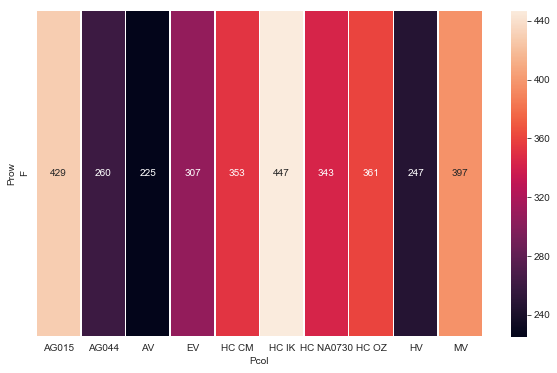

In [12]:
cell_for_patients = df_cox17.groupby(["Prow", "Pcol"])["Pfield"].count()
cell_for_patients = cell_for_patients.unstack(level=-1)
fig, ax = plt.subplots(figsize=(10,6)) 
sns.heatmap(cell_for_patients, linewidths=0.5, ax=ax, annot=True, fmt="0.00f")

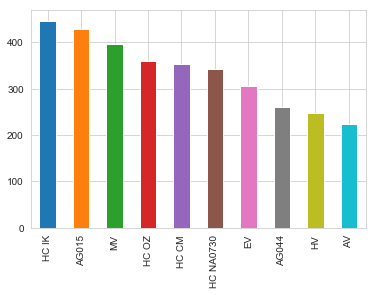

In [13]:
df_cox17["Pcol"].value_counts().plot(kind='bar')

<div class="alert alert-warning" role="warning">
  Do note, the number of cells is not identical. <BR> Is this difference OK?
</div>

## Group by patient


In [14]:
df_cox17["Cox17 area ratio*"] = df_cox17['Cox17 AREA']/df_cox17['CELL AREA']
df_cox17["Cox17 intensity ratio*"] = df_cox17["Cox17 INTENSITY"]/df_cox17['CELL INTENSITY']
df_cox17["Cox17 DxA ratio*"] = df_cox17['Cox17 DxA']/df_cox17['CELL DXA']

In [15]:
cox17_features = df_cox17.columns[df_cox17.columns.str.contains("Cox17")].tolist()
cox17_features

['Cox17 AREA',
 'Cox17 POS X',
 'Cox17 POS Y',
 'Cox17 INTENSITY',
 'Cox17 FORM FACTOR',
 'Cox17 COUNT',
 'Cox17 DxA',
 'Cox17 mean area',
 'Cox17 mean intesity',
 'Cox17 area ratio*',
 'Cox17 intensity ratio*',
 'Cox17 DxA ratio*']

In [16]:
cox17_features.remove('Cox17 COUNT')
cox17_features.remove('Cox17 mean area')
cox17_features.remove('Cox17 mean intesity')

In [17]:
df_grp_row = df_cox17.groupby("Pcol")

cox17_medians = df_grp_row[cox17_features].median()
display(cox17_medians)

Cox17 AREA  Cox17 POS X  Cox17 POS Y  Cox17 INTENSITY  Cox17 FORM FACTOR    Cox17 DxA  Cox17 area ratio*  Cox17 intensity ratio*  Cox17 DxA ratio*
Pcol                                                                                                                                                         
AG015          17.006     7321.563     7044.601       50020.5960              1.152   36828.1870           0.008106                3.883965          0.001463
AG044          36.494    10842.037    10858.567       74500.1605              1.130   85746.7105           0.022508                4.904969          0.003916
AV              8.028    10479.102     8516.981       59098.3500              1.251   17146.9970           0.004023                3.539695          0.000533
EV              8.239     7075.858     7174.320       49916.8330              1.249   18350.7180           0.002926                4.311176          0.000642
HC CM          59.257    19969.398    17597.929      132558.9380              1.136  131429.0460           0.043121                7.308502          0.005750
HC IK          18.802     8752.475     8972.011       64491.1050              1.147   43340.3830           0.005311                5.951593          0.001244
HC NA0730      17.323    10962.117    12150.783       86310.2310              1.211   42799.9980           0.005020                7.216333          0.001011
HC OZ          19.541     7911.224     8899.107       60188.5670              1.143   42434.9520           0.007165                5.452384          0.001514
HV             16.055     8924.031     8259.166       57114.0520              1.167   34334.2380           0.005700                4.740314          0.001138
MV              8.028     5686.911     5480.281       38740.9520              1.178   17731.9570           0.002677                3.442920          0.000610

In [18]:
plot_column(df_grp_row, 'Cox17 AREA')

In [19]:
plot_column(df_grp_row, 'Cox17 INTENSITY')

In [20]:
plot_column(df_grp_row, 'Cox17 area ratio*')

In [21]:
plot_column(df_grp_row, 'Cox17 DxA ratio*')

In [22]:
plot_column(df_grp_row, 'Cox17 DxA')

## Cox17 AREA
Cox17 AREA seems to be correlated with the cell area

Cox17 AREA  CELL AREA
Cox17 AREA    1.000000   0.021262
CELL AREA     0.021262   1.000000

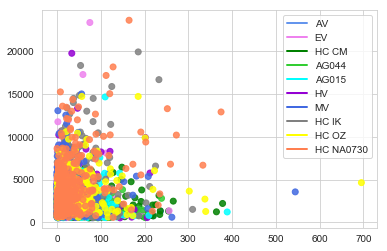

In [23]:
display(df_cox17[["Cox17 AREA", "CELL AREA"]].corr())

from matplotlib.lines import Line2D
lgn = [Line2D([0], [0], color=p['color'], lw=2, label='Line') for p in patients.values()]
plt.scatter(x=df_cox17["Cox17 AREA"], y=df_cox17["CELL AREA"], c=df_cox17["Pcol"].apply(lambda x: patients[x]['color']), alpha=0.85)
plt.legend(lgn, patients.keys())

Very weak correlation exists 

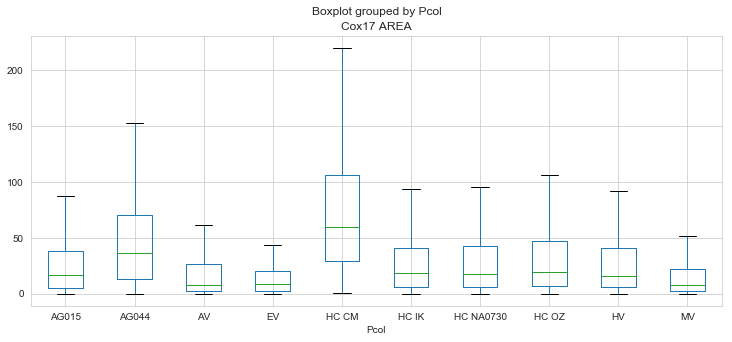

In [24]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Cox17 AREA",by="Pcol", ax=ax, showfliers=False )
plt.show()

In [25]:
p_values = compare_results(df_cox17, 'AV', 'Cox17 AREA')

In [26]:
print("Cox17 AREA - p values:\n"+"-"*35)
for k,v in p_values.items():
    print(f'{k}:\t\t {v:.6f}')

Cox17 AREA - p values:
-----------------------------------
AG015:		 0.000005
AG044:		 0.000000
EV:		 0.744365
HC CM:		 0.000000
HC IK:		 0.000000
HC NA0730:		 0.000000
HC OZ:		 0.000000
HV:		 0.000129
MV:		 0.582403


In [27]:
corrected_pval = pval_corrected(list(p_values.values()))
print("Cox17 total area - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cox17 total area - adjusted p values:
----------------------------------------
AG015:		 0.000044
AG044:		 0.000000
EV:		 1.000000
HC CM:		 0.000000
HC IK:		 0.000001
HC NA0730:		 0.000004
HC OZ:		 0.000000
HV:		 0.001157
MV:		 1.000000


<div class="alert alert-info" role="alert">
  Alon is significantly less then everybody expect Ella and me
</div>

In [28]:
p_values = compare_results(df_cox17, 'EV', 'Cox17 AREA')
corrected_pval = pval_corrected(list(p_values.values()))
print("Cox17 AREA - p values:\n"+"-"*35)
for k,v in p_values.items():
    print(f'{k}:\t\t {v:.6f}')
print("\n")
print("Cox17 AREA - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cox17 AREA - p values:
-----------------------------------
AG015:		 0.000000
AG044:		 0.000000
AV:		 0.255818
HC CM:		 0.000000
HC IK:		 0.000000
HC NA0730:		 0.000000
HC OZ:		 0.000000
HV:		 0.000000
MV:		 0.238310


Cox17 AREA - adjusted p values:
----------------------------------------
AG015:		 0.000000
AG044:		 0.000000
AV:		 1.000000
HC CM:		 0.000000
HC IK:		 0.000000
HC NA0730:		 0.000000
HC OZ:		 0.000000
HV:		 0.000003
MV:		 1.000000


<div class="alert alert-info" role="alert">
  Ella is significantly less then all the children expect Alon and Maydan
</div>

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


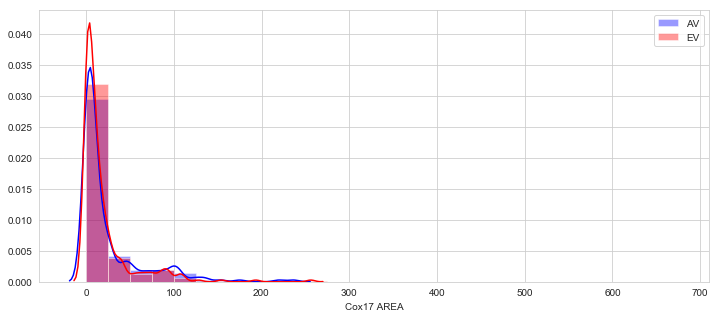

In [29]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

sns.distplot(df_grp_row["Cox17 AREA"].get_group('AV'), kde=True,bins=range(0, 700, 25), ax=ax, color='b')
sns.distplot(df_grp_row["Cox17 AREA"].get_group('EV'), kde=True, bins=range(0, 700, 25) ,ax=ax, color='r')
ax.legend(['AV','EV'])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


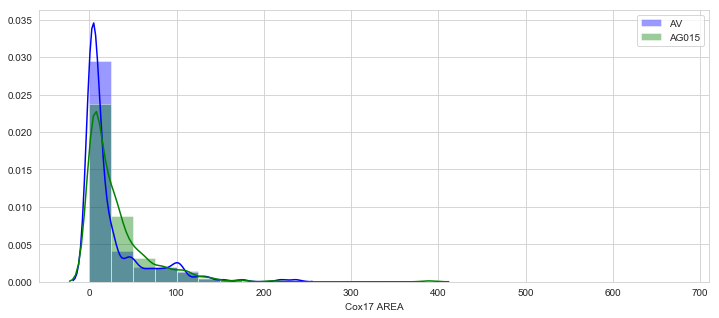

In [30]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

sns.distplot(df_grp_row["Cox17 AREA"].get_group('AV'), kde=True, bins=range(0, 700, 25), ax=ax, color='b')
sns.distplot(df_grp_row["Cox17 AREA"].get_group('AG015'), kde=True, bins=range(0, 700, 25) ,ax=ax, color='g')
ax.legend(['AV','AG015'])

## Cox 17 - Cell area

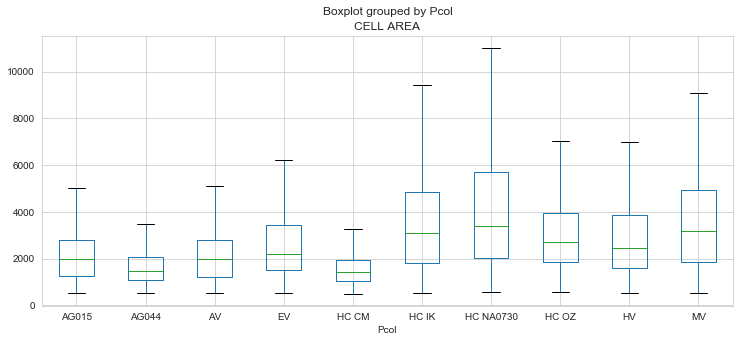

In [31]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="CELL AREA",by="Pcol", ax=ax, showfliers=False)
plt.show()

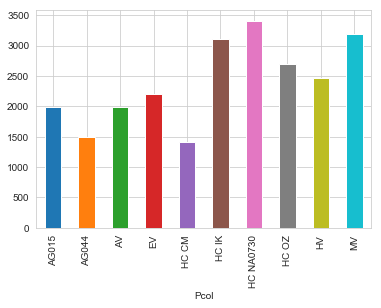

In [32]:
df_grp_row["CELL AREA"].median().plot(kind='bar')

In [33]:
p_values = compare_results(df_cox17, 'AV', 'CELL AREA', hyp_alternative='greater')

In [34]:
print("CELL AREA - p values:\n"+"-"*35)
for k,v in p_values.items():
    print(f'{k}:\t\t {v:.6f}')

CELL AREA - p values:
-----------------------------------
AG015:		 0.624935
AG044:		 0.000001
EV:		 0.999442
HC CM:		 0.000000
HC IK:		 1.000000
HC NA0730:		 1.000000
HC OZ:		 1.000000
HV:		 0.999999
MV:		 1.000000


In [35]:
corrected_pval = pval_corrected(list(p_values.values()))
print("CELL AREA - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

CELL AREA - adjusted p values:
----------------------------------------
AG015:		 1.000000
AG044:		 0.000005
EV:		 1.000000
HC CM:		 0.000000
HC IK:		 1.000000
HC NA0730:		 1.000000
HC OZ:		 1.000000
HV:		 1.000000
MV:		 1.000000


<div class="alert alert-info" role="alert">
  Alon cell area is not significantly larger then the other children 
</div>

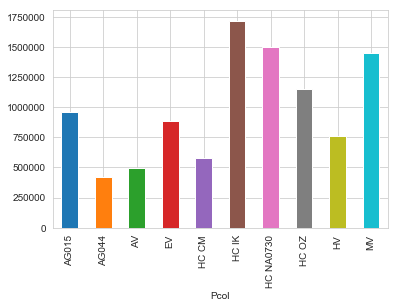

In [36]:
# Can we say the cells divide less and that's why they are bigger?
df_grp_row["CELL AREA"].sum().plot(kind='bar')

## Cox17 area ratio*

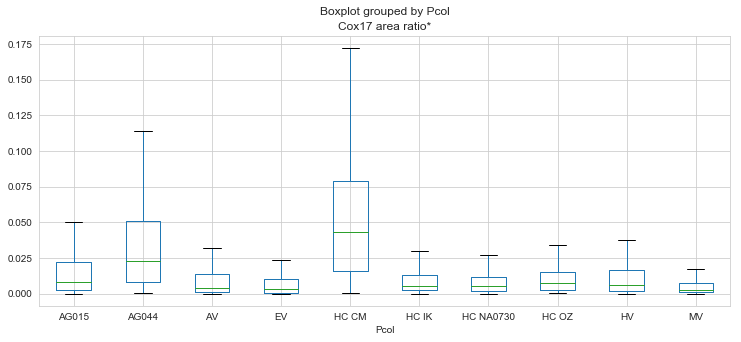

In [37]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Cox17 area ratio*",by="Pcol", ax=ax, showfliers=False)
plt.show()

Pcol
AG015        0.008106
AG044        0.022508
AV           0.004023
EV           0.002926
HC CM        0.043121
HC IK        0.005311
HC NA0730    0.005020
HC OZ        0.007165
HV           0.005700
MV           0.002677
Name: Cox17 area ratio*, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A3B2AFE128>]],
      dtype=object)

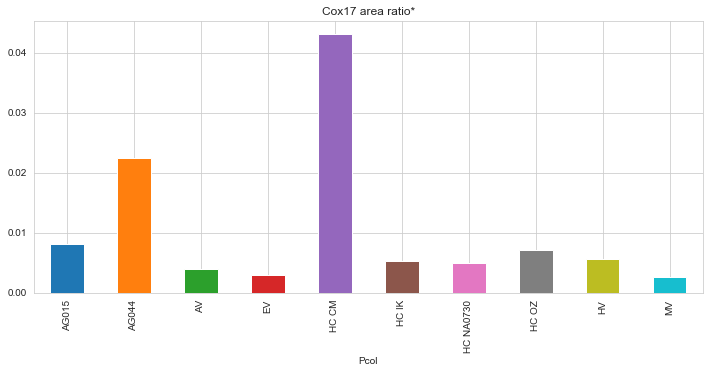

In [38]:
cox17_medians = df_grp_row["Cox17 area ratio*"].median()
display(cox17_medians)


# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)
# Set title
cox17_medians.plot(kind='bar', ax=ax, subplots=True, layout=(1,1))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


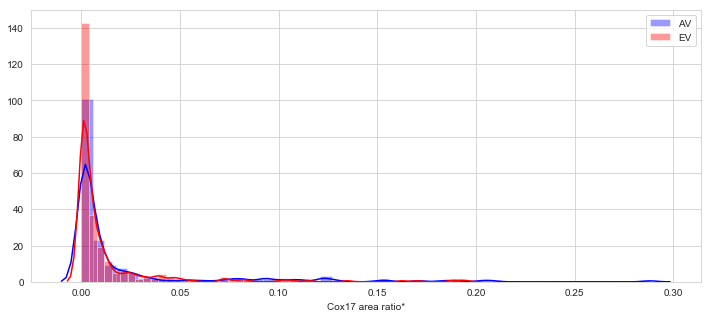

In [39]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

sns.distplot(df_grp_row["Cox17 area ratio*"].get_group('AV'), kde=True, ax=ax, color='b')
sns.distplot(df_grp_row["Cox17 area ratio*"].get_group('EV'), kde=True ,ax=ax, color='r')
ax.legend(['AV','EV'])

In [40]:
p_values = compare_results(df_cox17, 'AV', 'Cox17 area ratio*')

In [41]:
print("Cox17 area ratio* - p values:\n"+"-"*35)
for k,v in p_values.items():
    print(f'{k}:\t\t {v:.6f}')

Cox17 area ratio* - p values:
-----------------------------------
AG015:		 0.000019
AG044:		 0.000000
EV:		 0.943369
HC CM:		 0.000000
HC IK:		 0.026537
HC NA0730:		 0.106722
HC OZ:		 0.000923
HV:		 0.032358
MV:		 0.996729


In [42]:
corrected_pval = pval_corrected(list(p_values.values()))
print("Cox17 area ratio* - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cox17 area ratio* - adjusted p values:
----------------------------------------
AG015:		 0.000173
AG044:		 0.000000
EV:		 1.000000
HC CM:		 0.000000
HC IK:		 0.238830
HC NA0730:		 0.960498
HC OZ:		 0.008308
HV:		 0.291218
MV:		 1.000000


<div class="alert alert-info" role="alert">
  Alon Cox17 area ratio is significantly less then the other children (except Ella)
</div>

In [43]:
p_values = compare_results(df_cox17, 'EV', 'Cox17 area ratio*')
corrected_pval = pval_corrected(list(p_values.values()))
print("Cox17 area ratio* - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cox17 area ratio* - adjusted p values:
----------------------------------------
AG015:		 0.000000
AG044:		 0.000000
AV:		 0.510264
HC CM:		 0.000000
HC IK:		 0.000055
HC NA0730:		 0.002858
HC OZ:		 0.000000
HV:		 0.000450
MV:		 1.000000


<div class="alert alert-info" role="alert">
  Ella Cox17 area ratio is significantly less then the other children (except Alon)
</div>

## Cox17 DxA ratio*

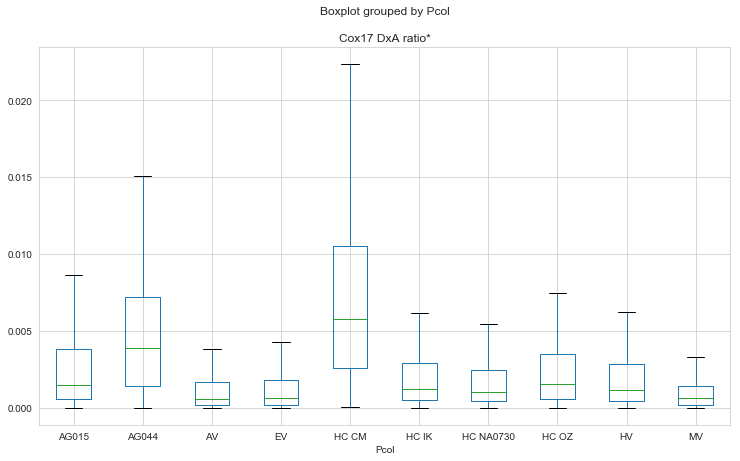

In [44]:
# Create a figure of given size
fig = plt.figure(figsize=(12,7))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Cox17 DxA ratio*",by="Pcol", ax=ax, showfliers=False)
plt.show()

Pcol
AG015        0.001463
AG044        0.003916
AV           0.000533
EV           0.000642
HC CM        0.005750
HC IK        0.001244
HC NA0730    0.001011
HC OZ        0.001514
HV           0.001138
MV           0.000610
Name: Cox17 DxA ratio*, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A3B415CE10>]],
      dtype=object)

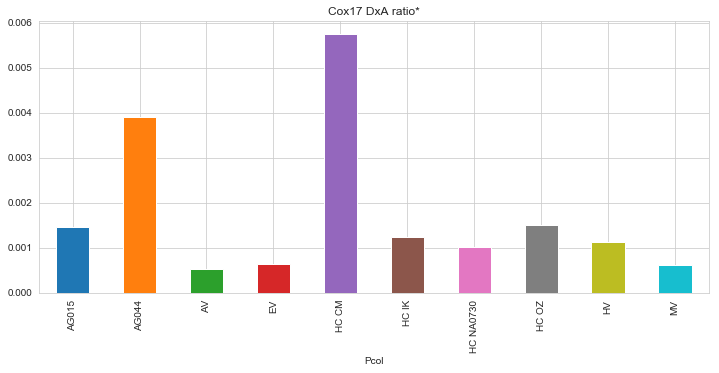

In [45]:
cox17_medians = df_grp_row["Cox17 DxA ratio*"].median()
display(cox17_medians)


# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)
# Set title
cox17_medians.plot(kind='bar', ax=ax, subplots=True, layout=(1,1))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


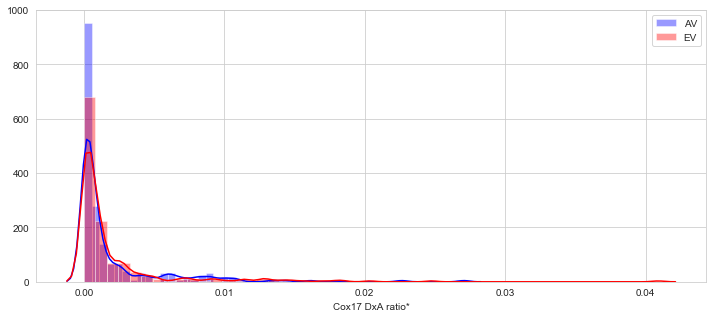

In [46]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

sns.distplot(df_grp_row["Cox17 DxA ratio*"].get_group('AV'), kde=True, ax=ax, color='b')
sns.distplot(df_grp_row["Cox17 DxA ratio*"].get_group('EV'), kde=True ,ax=ax, color='r')
ax.legend(['AV','EV'])

In [47]:
p_values = compare_results(df_cox17, 'AV', 'Cox17 DxA ratio*')
corrected_pval = pval_corrected(list(p_values.values()))
print("Cox17 DxA ratio* - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cox17 DxA ratio* - adjusted p values:
----------------------------------------
AG015:		 0.000000
AG044:		 0.000000
EV:		 1.000000
HC CM:		 0.000000
HC IK:		 0.000000
HC NA0730:		 0.000127
HC OZ:		 0.000000
HV:		 0.000036
MV:		 1.000000


In [48]:
p_values = compare_results(df_cox17, 'EV', 'Cox17 DxA ratio*')
corrected_pval = pval_corrected(list(p_values.values()))
print("Cox17 DxA ratio* - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cox17 DxA ratio* - adjusted p values:
----------------------------------------
AG015:		 0.000000
AG044:		 0.000000
AV:		 1.000000
HC CM:		 0.000000
HC IK:		 0.000000
HC NA0730:		 0.001040
HC OZ:		 0.000000
HV:		 0.000212
MV:		 1.000000


# Cox17 and Mito

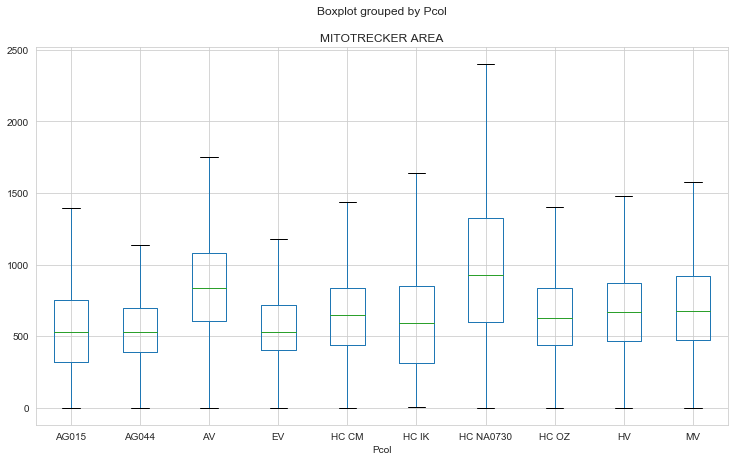

In [49]:
# Create a figure of given size
fig = plt.figure(figsize=(12,7))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="MITOTRECKER AREA",by="Pcol", ax=ax, showfliers=False)
plt.show()

In [50]:
df_cox17['Mito AREA*'] = df_cox17['MITOTRECKER AREA'] / df_cox17["CELL AREA"]

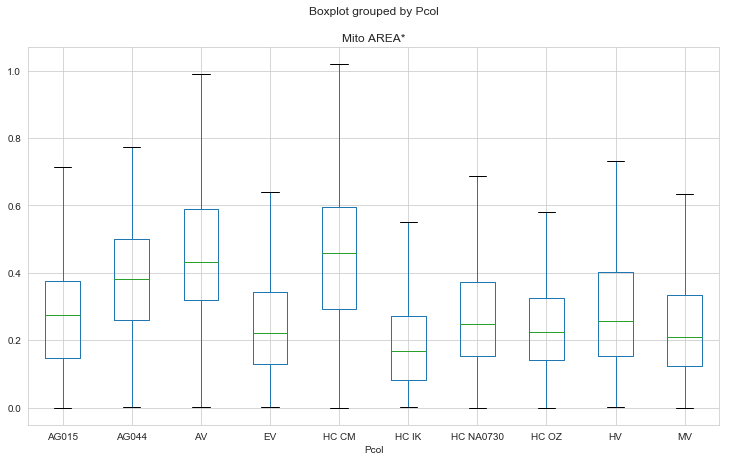

In [51]:
# Create a figure of given size
fig = plt.figure(figsize=(12,7))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Mito AREA*",by="Pcol", ax=ax, showfliers=False)
plt.show()

In [52]:
df_cox17['Cox17 per Mito AREA'] = df_cox17['Cox17 AREA'] / df_cox17["MITOTRECKER AREA"]

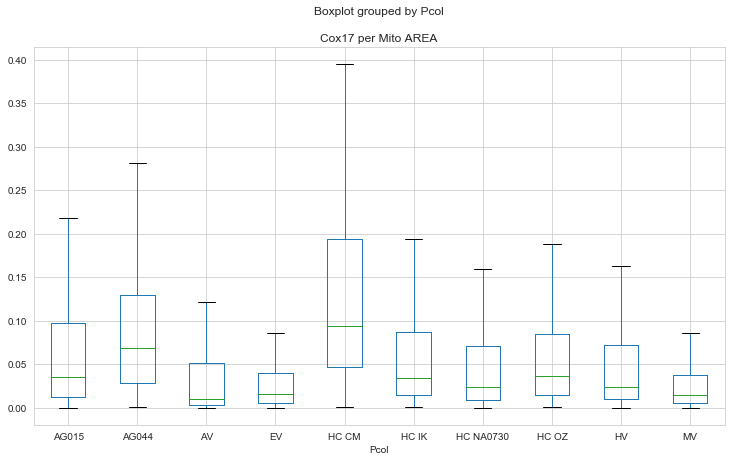

In [53]:
# Create a figure of given size
fig = plt.figure(figsize=(12,7))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Cox17 per Mito AREA",by="Pcol", ax=ax, showfliers=False)
plt.show()

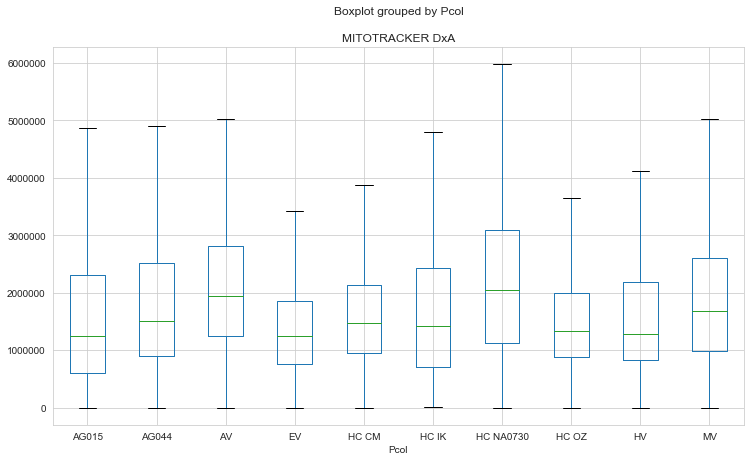

In [54]:
# Create a figure of given size
fig = plt.figure(figsize=(12,7))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="MITOTRACKER DxA",by="Pcol", ax=ax, showfliers=False)
plt.show()

In [55]:
df_cox17['Mito DxA*'] = df_cox17['MITOTRACKER DxA'] / df_cox17["CELL AREA"]

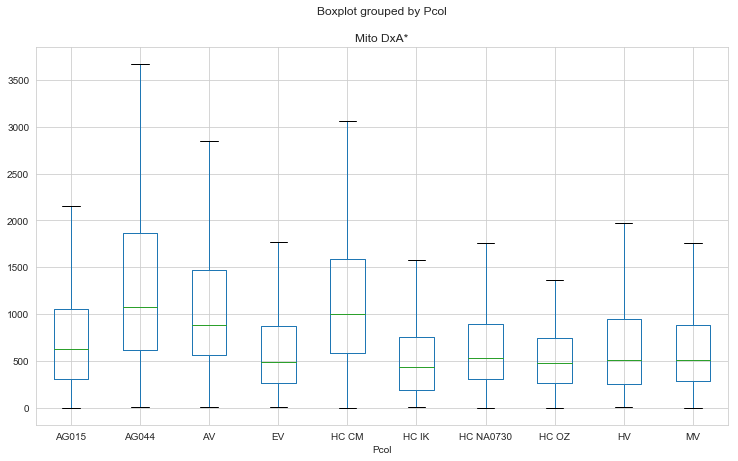

In [56]:
# Create a figure of given size
fig = plt.figure(figsize=(12,7))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Mito DxA*",by="Pcol", ax=ax, showfliers=False)
plt.show()

In [57]:
df_cox17['Cox17 per Mito DxA'] = df_cox17["Cox17 DxA"]/ df_cox17['MITOTRACKER DxA'] 

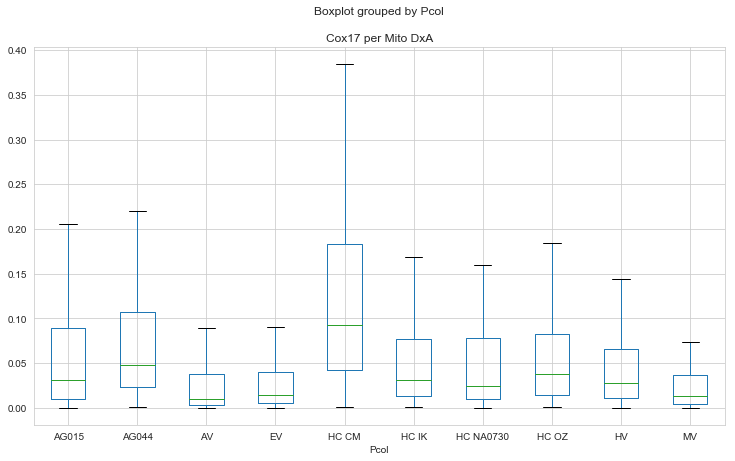

In [58]:
# Create a figure of given size
fig = plt.figure(figsize=(12,7))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Cox17 per Mito DxA",by="Pcol", ax=ax, showfliers=False)
plt.show()

In [103]:
p_values = compare_results(df_cox17, 'AV', 'Cox17 per Mito DxA')
corrected_pval = pval_corrected(list(p_values.values()))
print("Cox17 per Mito DxA - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cox17 per Mito DxA - adjusted p values:
----------------------------------------
AG015:		 0.000000
AG044:		 0.000000
EV:		 0.114853
HC CM:		 0.000000
HC IK:		 0.000000
HC NA0730:		 0.000000
HC OZ:		 0.000000
HV:		 0.000000
MV:		 0.513716


In [104]:
p_values = compare_results(df_cox17, 'EV', 'Cox17 per Mito DxA')
corrected_pval = pval_corrected(list(p_values.values()))
print("Cox17 per Mito DxA - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cox17 per Mito DxA - adjusted p values:
----------------------------------------
AG015:		 0.000000
AG044:		 0.000000
AV:		 1.000000
HC CM:		 0.000000
HC IK:		 0.000000
HC NA0730:		 0.000013
HC OZ:		 0.000000
HV:		 0.000017
MV:		 1.000000


# GFER

## Loading data

In [59]:
data_path = ".\\Data\\20181231 - Cox17 GFER\\gfer mito by cell.xls"

In [60]:
df_gfer = pd.read_excel(data_path, header=1)

df_gfer.drop("Target Set",axis=1, inplace=True)
df_gfer.columns = df_gfer.columns.str.replace("TMRE", "GFER")
loc_df = df_gfer.Section.str.extract("(.*) - (.*) \(fld (.*)\).*",expand=True)
loc_df.columns=["Prow","Pcol", "Pfield"]
loc_df.Pcol = loc_df.Pcol.astype(np.int16)
df_gfer = df_gfer.join(loc_df)
df_gfer.drop("Section",axis=1, inplace=True)
df_gfer.Pcol.replace([2,3,4,5,6,7,8,9,10,11], 
                ["AV", "HC CM", "EV", "AG044", "HV", "AG015", "HC IK", "MV", "HC OZ", "HC NA0730"],
               inplace=True)
df_gfer = df_gfer.join(patients_df, on='Pcol')

df_gfer.sample(7)

Target  GFER AREA  GFER POS X  GFER POS Y  GFER INTENSITY  GFER FORM FACTOR  GFER COUNT     GFER DxA  GFER mean area  GFER mean intesity  MITOTRECKER AREA  MITO POS Y  MITOTRACKER DxA  MITOTRACKER FORM FACTOR  MITOTRACKER INTENSITY  MITOTRACKER COUNT  MITO POS X  NUCLEAR DXA  NUC CG X  NUC CG Y  NUC FORM FACTOR  NUC MEDIAN DENSITY  NUCLEAR PARIMETER  NUCLEAR WRMI  NUCLEUS MAX CHORD  NUCLEAR AVG DIAMETER  NUCLEAR MED DIAMETER  NUCLEAR AREA  NUCLEAR INTENSITY  CELL INTENSITY      CELL DXA  CELL AREA  CELL FORM FACTOR  CELL FIBER LENGTH  CELL END NODES  CELL PARIEMETER  CELL AVG  DIAMETER  CELL MED DIAMETER  CELL FRMI  CELL LENGTH  CELL CROSSING POINTS  CELL BRANCH NODES Prow       Pcol Pfield       age      color gender
989       25     87.142   41074.202    6455.688      261962.768             1.244          72   344633.666           1.210            3954.855           230.688    6749.251       597170.246                    1.066             217784.474                 72   40830.280   439318.921   575.730    92.045            0.964              1904.5             54.760         0.941             18.946                23.293                26.768       230.055           1909.628        7830.671  2.838783e+07   3625.210             0.160            452.685              20          532.980              23.293             26.768      0.897      139.120                     2                 15    E         EV     18       264     violet      F
779       11    211.464   14243.832   14974.906      231118.302             1.190          67  1089944.563           3.156            5154.269           591.826    1458.733      3531119.215                    0.923              35062.036                  6    1342.399   478885.266   209.353   225.172            0.793              3588.0             46.407         1.045             18.650                15.479                17.078       135.836           3525.472       28442.815  2.795217e+07    982.750             0.183            249.176              16          259.759              15.479             17.078      1.043       67.367                     1                 13    E         EV      8       264     violet      F
3112      11     76.157   18886.818   45413.170      375686.486             1.263         112   285003.234           0.680            3742.323          1239.950    5921.735      3058308.428                    1.080              44978.364                 15    2551.461   587128.961   175.378   389.231            0.929              2923.0             54.208         0.952             19.314                22.406                18.552       217.274           2702.253       11995.239  6.202931e+07   5171.161             0.167            520.498              20          623.307              22.406             18.552      0.777      210.017                     0                 14    E  HC NA0730     10      2544      coral      M
729       22    165.306   33337.642   16491.953      370424.440             1.270         100   796631.158           1.653            4819.142            49.644    7788.117       218019.080                    1.111             202236.243                 54   17831.814   475353.958   326.270   171.308            0.881              2716.0             50.398         1.054             19.179                16.228                13.017       178.086           2669.232       13812.323  4.081117e+07   2954.692             0.153            458.841              23          492.031              16.228             13.017      0.938      162.792                     2                 19    E         EV      5       264     violet      F
2608       2     89.149   45558.216   57220.129      380570.044             1.108         105   353218.045           0.849            3962.116           625.098    1655.577      1134229.565                    0.640               5254.301                  3    1320.013   600406.328   434.110   548.240            0.874              3214

In [61]:
df_gfer.describe()

Target    GFER AREA     GFER POS X     GFER POS Y  GFER INTENSITY  GFER FORM FACTOR   GFER COUNT      GFER DxA  GFER mean area  GFER mean intesity  MITOTRECKER AREA     MITO POS Y  MITOTRACKER DxA  MITOTRACKER FORM FACTOR  MITOTRACKER INTENSITY  MITOTRACKER COUNT     MITO POS X   NUCLEAR DXA     NUC CG X     NUC CG Y  NUC FORM FACTOR  NUC MEDIAN DENSITY  NUCLEAR PARIMETER  NUCLEAR WRMI  NUCLEUS MAX CHORD  NUCLEAR AVG DIAMETER  NUCLEAR MED DIAMETER  NUCLEAR AREA  NUCLEAR INTENSITY  CELL INTENSITY      CELL DXA     CELL AREA  CELL FORM FACTOR  CELL FIBER LENGTH  CELL END NODES  CELL PARIEMETER  CELL AVG  DIAMETER  CELL MED DIAMETER    CELL FRMI  CELL LENGTH  CELL CROSSING POINTS  CELL BRANCH NODES
count  3285.000000  3285.000000    3285.000000    3285.000000    3.285000e+03       3285.000000  3285.000000  3.285000e+03     3285.000000         3285.000000       3285.000000    3285.000000     3.285000e+03              3285.000000            3285.000000        3285.000000    3285.000000  3.285000e+03  3285.000000  3285.000000      3285.000000         3285.000000        3285.000000   3285.000000        3285.000000           3285.000000           3285.000000   3285.000000        3285.000000     3285.000000  3.285000e+03   3285.000000       3285.000000        3285.000000     3285.000000      3285.000000         3285.000000        3285.000000  3285.000000  3285.000000           3285.000000        3285.000000
mean      9.855403   180.343545   23310.848794   20011.833344    2.271443e+05          1.190588    65.622222  8.220894e+05        5.771151         4285.104526        728.889409    9040.446334     2.407004e+06                 1.072145           91899.552019          28.661492   10070.668199  4.726838e+05   331.725135   334.425646         0.891731         2241.540639          56.018769      0.993046          20.994613             17.735946             16.810494    224.082315        2160.644797    13477.916945  3.258068e+07   2819.786101          0.190234         419.982474       21.122374       477.379765           17.735946          16.810494     0.970408   141.758818              0.939117          15.921461
std       6.439835   133.068259   25306.259981   19430.965334    2.067205e+05          0.084657    58.825078  7.271236e+05       14.268176         1060.853179        465.563238    9389.935491     2.031412e+06                 0.146440           85870.786141          27.048528   12187.770258  1.100482e+05   159.030278   156.814766         0.064951          548.222279           6.374044      0.112675           2.773156              8.036142              8.865371     46.185635         541.519059     5254.623809  1.868590e+07   2112.935749          0.117454         263.021661       13.124704       260.496874            8.036142           8.865371     0.234207    58.720922              1.243231          11.193266
min       1.000000     0.106000      26.650000      28.600000    3.014000e+03          0.555000     1.000000  3.183590e+02        0.106000         3014.000000          0.106000      23.645000     1.483000e+02                 0.155000            1352.412000           1.000000      29.581000  5.723376e+03    20.495000    13.601000         0.431000           64.000000          32.433000      0.482000          11.454000              3.850000              2.398000     74.889000          64.048000     5789.178000  5.580728e+06    508.486000          0.022000          56.996000        3.000000        90.799000            3.850000           2.398000     0.424000    29.473000              0.000000           1.000000
25%       5.000000    90.311000    6110.547000    7106.041000    9.017787e+04          1.145000    27.000000  3.394056e+05        1.205000         3696.640000        479.439000    2789.937000     1.183856e+06                 1.009000           35667.840000          11.000000    2526.782000  4.286232e+05   198.354000   204.495000         0.860000         1916.000000          52.312000      0.924000          19.256000        

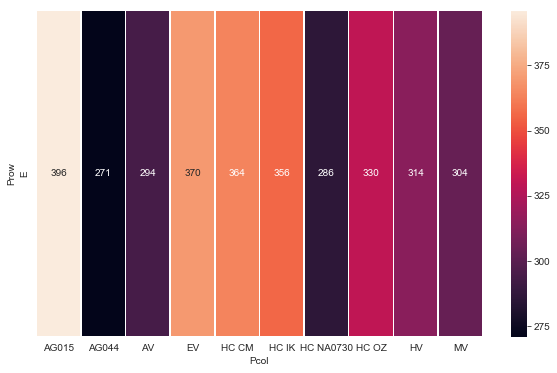

In [62]:
cell_for_patients = df_gfer.groupby(["Prow", "Pcol"])["Pfield"].count()
cell_for_patients = cell_for_patients.unstack(level=-1)
fig, ax = plt.subplots(figsize=(10,6)) 
sns.heatmap(cell_for_patients, linewidths=0.5, ax=ax, annot=True, fmt="0.00f")

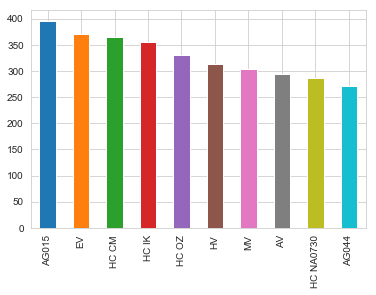

In [63]:
df_gfer["Pcol"].value_counts().plot(kind='bar')

## Group by patient

In [64]:
df_gfer["GFER area ratio*"] = df_gfer['GFER AREA']/df_gfer['CELL AREA']
df_gfer["GFER intensity ratio*"] = df_gfer["GFER INTENSITY"]/df_gfer['CELL INTENSITY']
df_gfer["GFER DxA ratio*"] = df_gfer["GFER DxA"]/df_gfer['CELL DXA']

In [65]:
df_grp_gfer_row = df_gfer.groupby("Pcol")
GFER_features = df_gfer.columns[df_gfer.columns.str.contains("GFER")].tolist()
GFER_features

['GFER AREA',
 'GFER POS X',
 'GFER POS Y',
 'GFER INTENSITY',
 'GFER FORM FACTOR',
 'GFER COUNT',
 'GFER DxA',
 'GFER mean area',
 'GFER mean intesity',
 'GFER area ratio*',
 'GFER intensity ratio*',
 'GFER DxA ratio*']

In [66]:
GFER_features.remove('GFER COUNT')
GFER_features.remove('GFER mean area')
GFER_features.remove('GFER mean intesity')

In [67]:
GFER_medians = df_grp_gfer_row[GFER_features].median()
display(GFER_medians)

GFER AREA  GFER POS X  GFER POS Y  GFER INTENSITY  GFER FORM FACTOR      GFER DxA  GFER area ratio*  GFER intensity ratio*  GFER DxA ratio*
Pcol                                                                                                                                                  
AG015       213.1015  12356.3755  11792.5455     141945.5065            1.1910  8.821617e+05          0.103783               9.986585         0.033505
AG044       271.1430  13342.6080  12995.2940     155301.2020            1.1640  1.302221e+06          0.196959               9.523843         0.060575
AV          184.6355  16846.0140  14995.0250     184142.1975            1.2050  8.127280e+05          0.079052              14.815523         0.033893
EV          179.8295  12400.2090  10392.7325     138443.3330            1.2060  7.886360e+05          0.069230              11.244274         0.026520
HC CM       212.9430  18825.7835  16085.0395     192381.0495            1.1780  1.050320e+06          0.139475              11.319803         0.039388
HC IK       137.5260  12268.2940  13483.1185     154578.1235            1.1925  5.327308e+05          0.038425              15.083109         0.015857
HC NA0730    63.0590  24371.4510  25119.5125     282213.0445            1.1890  2.325643e+05          0.016157              23.817821         0.005976
HC OZ        84.8185  18071.6710  16735.7265     201088.3035            1.1835  3.022997e+05          0.027090              15.381864         0.008563
HV          164.2490  13348.0020  12749.4670     149120.6720            1.1860  6.370439e+05          0.057437              12.369230         0.022303
MV           37.2860  16149.6215  15281.1950     175691.5655            1.1985  1.413028e+05          0.011274              15.458759         0.003961

In [68]:
plot_column(df_grp_gfer_row, 'GFER AREA', agg='50%')

In [69]:
plot_column(df_grp_gfer_row, 'GFER area ratio*')

In [70]:
plot_column(df_grp_gfer_row, 'GFER DxA ratio*')

In [71]:
plot_column(df_grp_gfer_row, 'GFER INTENSITY')

In [72]:
plot_column(df_grp_gfer_row, 'GFER intensity ratio*')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


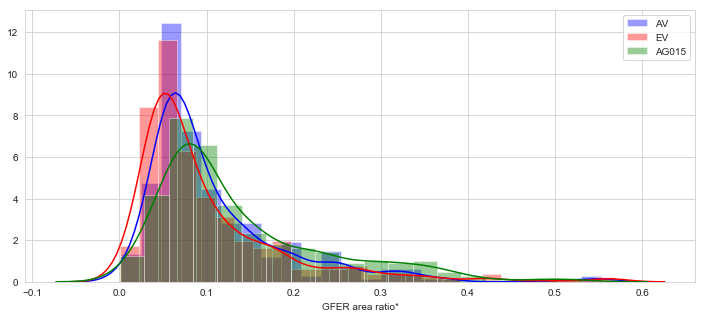

In [73]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

sns.distplot(df_grp_gfer_row["GFER area ratio*"].get_group('AV'), kde=True, ax=ax, color='b')
sns.distplot(df_grp_gfer_row["GFER area ratio*"].get_group('EV'), kde=True ,ax=ax, color='r')
sns.distplot(df_grp_gfer_row["GFER area ratio*"].get_group('AG015'), kde=True ,ax=ax, color='g')

ax.legend(['AV','EV', 'AG015'])

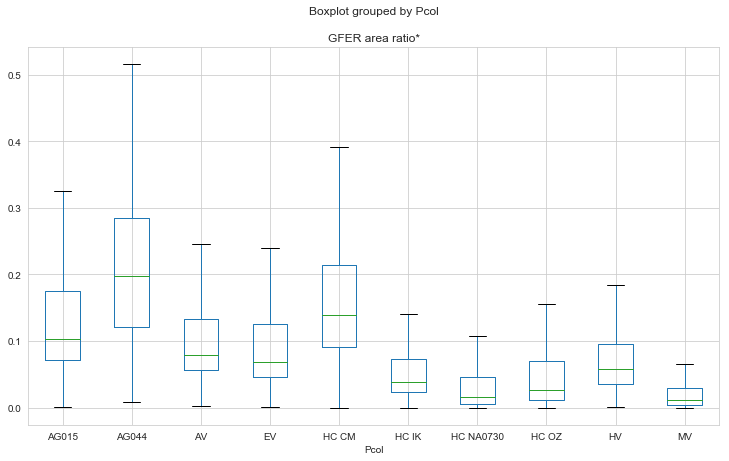

In [74]:
# Create a figure of given size
fig = plt.figure(figsize=(12,7))
# Add a subplot
ax = fig.add_subplot(111)

df_gfer.boxplot(column="GFER area ratio*",by="Pcol", ax=ax, showfliers=False)
plt.show()

In [75]:
p_values = compare_results(df_gfer, 'AV', 'GFER area ratio*', hyp_alternative='less')
corrected_pval = pval_corrected(list(p_values.values()))
print("Cell area - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cell area - adjusted p values:
----------------------------------------
AG015:		 0.000008
AG044:		 0.000000
EV:		 1.000000
HC CM:		 0.000000
HC IK:		 1.000000
HC NA0730:		 1.000000
HC OZ:		 1.000000
HV:		 1.000000
MV:		 1.000000


<div class="alert alert-info" role="alert">
  Alon GFER area ratio* is significantly less than the other children (except Ella) but not the adults
</div>

## GFER DxA ratio*

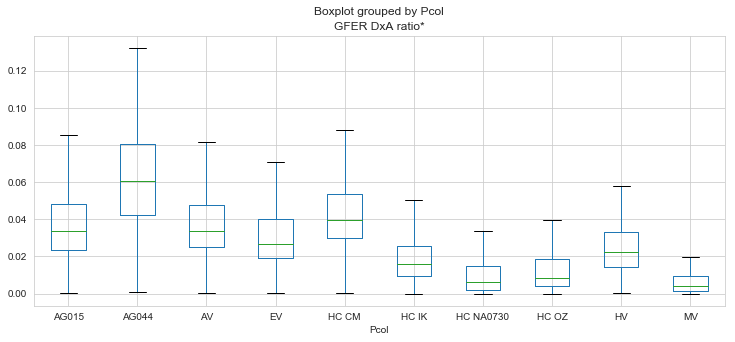

In [76]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_gfer.boxplot(column="GFER DxA ratio*",by="Pcol", ax=ax, showfliers=False)
plt.show()

In [77]:
p_values = compare_results(df_gfer, 'AV', 'GFER DxA ratio*', hyp_alternative='less')
corrected_pval = pval_corrected(list(p_values.values()))
print("Cell area - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cell area - adjusted p values:
----------------------------------------
AG015:		 1.000000
AG044:		 0.000000
EV:		 1.000000
HC CM:		 0.000213
HC IK:		 1.000000
HC NA0730:		 1.000000
HC OZ:		 1.000000
HV:		 1.000000
MV:		 1.000000


<div class="alert alert-info" role="alert">
  Alon GFER DxA ratio* is <b> not </b> significantly lower then the rest of the children.
</div>

In [78]:
p_values = compare_results(df_gfer, 'EV', 'GFER DxA ratio*', hyp_alternative='less')
corrected_pval = pval_corrected(list(p_values.values()))
print("Cell area - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cell area - adjusted p values:
----------------------------------------
AG015:		 0.000006
AG044:		 0.000000
AV:		 0.000000
HC CM:		 0.000000
HC IK:		 1.000000
HC NA0730:		 1.000000
HC OZ:		 1.000000
HV:		 1.000000
MV:		 1.000000


<div class="alert alert-info" role="alert">
  Ella GFER DxA ratio* is significantly lower then the rest of the children including Alon.
</div>

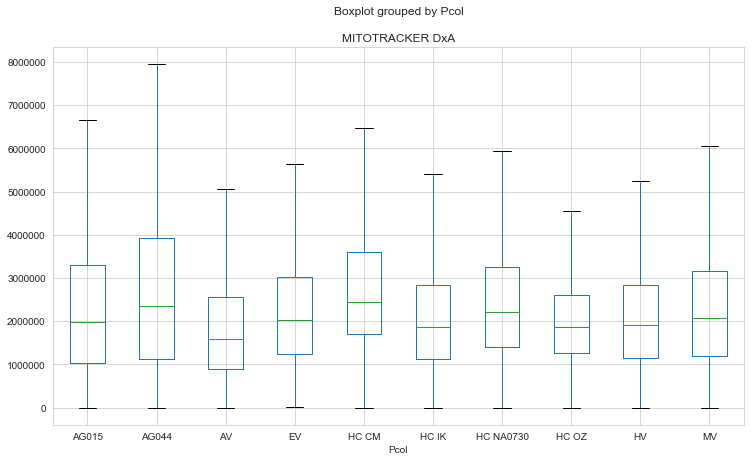

In [79]:
# Create a figure of given size
fig = plt.figure(figsize=(12,7))
# Add a subplot
ax = fig.add_subplot(111)

df_gfer.boxplot(column="MITOTRACKER DxA",by="Pcol", ax=ax, showfliers=False)
plt.show()

In [80]:
df_gfer['GFER per Mito DxA'] = df_gfer["GFER DxA"]/ df_gfer['MITOTRACKER DxA'] 
df_gfer['GFER per Mito AREA'] = df_gfer['GFER AREA'] / df_gfer["MITOTRECKER AREA"]

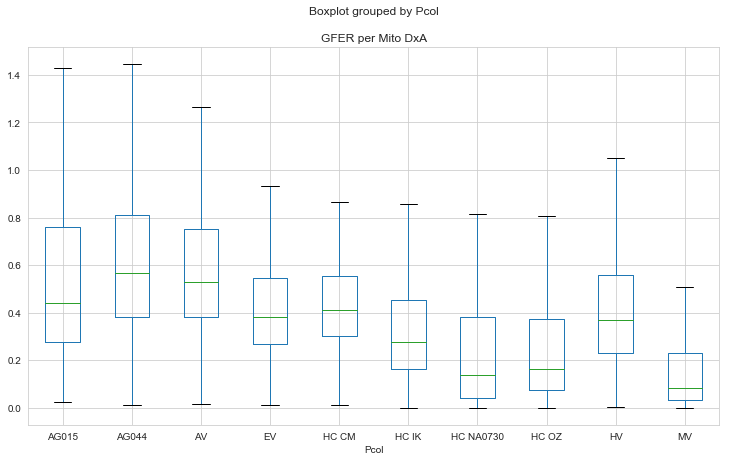

In [81]:
# Create a figure of given size
fig = plt.figure(figsize=(12,7))
# Add a subplot
ax = fig.add_subplot(111)

df_gfer.boxplot(column="GFER per Mito DxA",by="Pcol", ax=ax, showfliers=False)
plt.show()

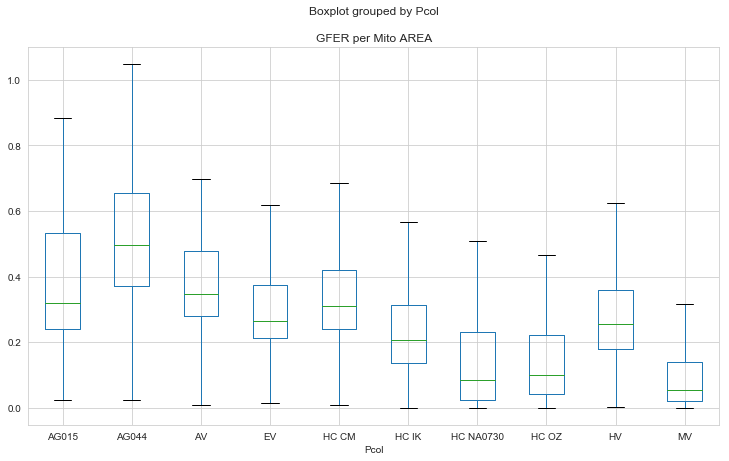

In [82]:
# Create a figure of given size
fig = plt.figure(figsize=(12,7))
# Add a subplot
ax = fig.add_subplot(111)

df_gfer.boxplot(column="GFER per Mito AREA",by="Pcol", ax=ax, showfliers=False)
plt.show()

# Effecting Factors

## Age

### Cox17

In [83]:
df_cox17["Age_binned"]=pd.cut(df_cox17.age, [0,12*12*4,21*12*4,80*12*4], labels=['Child', 'Adolescent', 'Adult'])

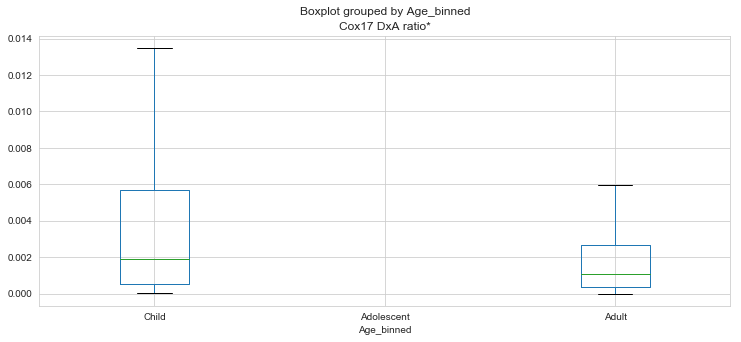

In [84]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Cox17 DxA ratio*",by="Age_binned", ax=ax, showfliers=False)
plt.show()

In [85]:
df_grp_age = df_cox17.groupby("Age_binned")
child_data = df_grp_age["Cox17 DxA ratio*"].get_group('Child')
adult_data = df_grp_age["Cox17 DxA ratio*"].get_group('Adult')
stat, p = mannwhitneyu(child_data, adult_data, alternative="greater")
print(f"p vlaue: {p:0.5f}")

p vlaue: 0.00000


### GFER

In [86]:
df_gfer["Age_binned"]=pd.cut(df_gfer.age, [0,12*12*4,21*12*4,80*12*4], labels=['Child', 'Adolescent', 'Adult'])

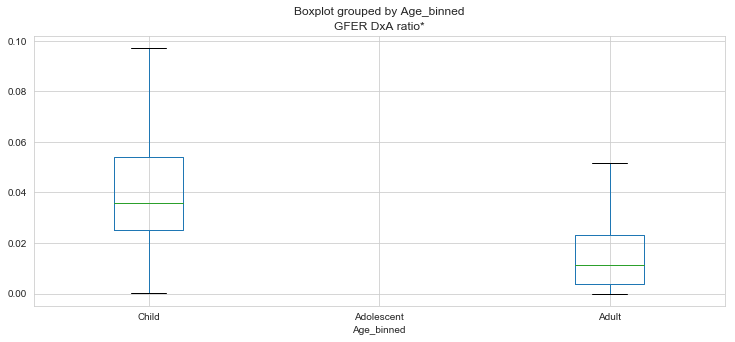

In [87]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_gfer.boxplot(column="GFER DxA ratio*",by="Age_binned", ax=ax, showfliers=False)
plt.show()

In [88]:
df_grp_age = df_gfer.groupby("Age_binned")
child_data = df_grp_age["GFER DxA ratio*"].get_group('Child')
adult_data = df_grp_age["GFER DxA ratio*"].get_group('Adult')
stat, p = mannwhitneyu(child_data, adult_data, alternative="greater")
print(f"p vlaue: {p:0.5f}")

p vlaue: 0.00000


## Gender

### Cox17

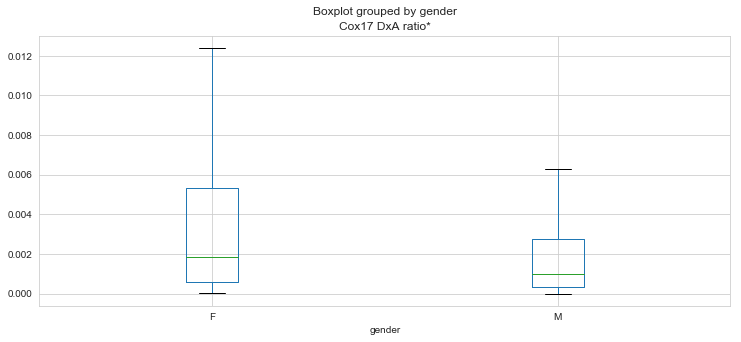

In [89]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Cox17 DxA ratio*",by="gender", ax=ax, showfliers=False)
plt.show()

In [90]:
female_data = df_cox17.loc[df_cox17.gender=="F","Cox17 DxA ratio*"]
male_data = df_cox17.loc[df_cox17.gender=="M","Cox17 DxA ratio*"]
stat, p = mannwhitneyu(female_data, male_data, alternative="greater")
print(f"p vlaue: {p:0.5f}")

p vlaue: 0.00000


### GFER

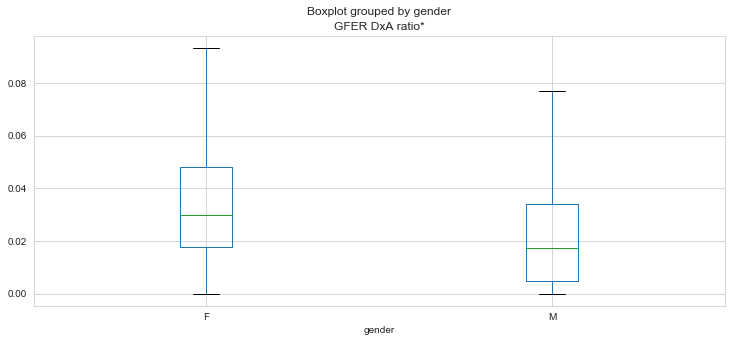

In [91]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_gfer.boxplot(column="GFER DxA ratio*",by="gender", ax=ax, showfliers=False)
plt.show()

In [92]:
female_data = df_gfer.loc[df_gfer.gender=="F","GFER DxA ratio*"]
male_data = df_gfer.loc[df_gfer.gender=="M","GFER DxA ratio*"]
stat, p = mannwhitneyu(female_data, male_data, alternative="greater")
print(f"p vlaue: {p:0.5f}")

p vlaue: 0.00000


## Conclusions
Female have more GFER and COX then Male   
Children have more GFER and COX then adults

# Data Comparisons
<div class="alert alert-warning" role="alert">
    NOTE: This section is still a <b>WORK IN PROGRESS</b> !!!
</div>
Cox17 and GFER are on the same plate and it should be possible to prove they are the same (assuming the different antibodies does not effect external parameters differently).  
Lets check inside each parameter for each person does the distribution is similar between "plates"


In [93]:
# Cox17 Cell area median
df_grp_row = df_cox17.groupby("Pcol")

plot_column(df_grp_row, 'CELL AREA')

In [94]:
# GFER Cell area median
plot_column(df_grp_gfer_row, 'CELL AREA')

The general pattern, by medians, look almost the same. Can this be translated into the by cell view?

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:2257: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


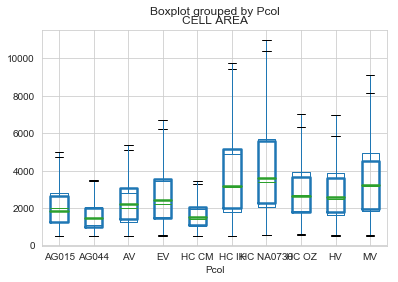

In [95]:
ax = df_cox17.boxplot(column="CELL AREA",by="Pcol", return_type='axes', showfliers=False)

boxprops = dict(linestyle='-', linewidth=2.5 )
medianprops = dict(linestyle='-', linewidth=2.5)
df_gfer.boxplot(column="CELL AREA",by="Pcol", ax=ax, boxprops=boxprops,medianprops=medianprops, showfliers=False )
plt.show()

The bold lines belong to GFER while the other is Cox17.  
Normalization by one of the patients doesn't look good as for instance *HC IK* and *HC NA0730* differences are in opposite direction.

In [96]:
patients_names = df_cox17.Pcol.unique()
for patient in patients_names:
    stat, p = mannwhitneyu(df_cox17.loc[df_cox17.Pcol==patient, 'CELL AREA'], df_gfer.loc[df_gfer.Pcol==patient, 'CELL AREA'], alternative='two-sided')
    print(f"{patient}: {p:0.00}")

AV: 0.03
HC CM: 0.2
EV: 0.5
AG044: 0.7
HV: 0.8
AG015: 0.2
HC IK: 0.5
MV: 1e+00
HC OZ: 0.2
HC NA0730: 0.6


The p value is 0.05 or above and there distributions cannot be considered as different but for some the distance is quite big.  
Maybe Kolmogorov-Smirnov test will help us? It have null hypothesis that 2 independent samples are drawn from the same continuous distribution.

In [97]:
from scipy import stats

patients_names = df_cox17.Pcol.unique()
for patient in patients_names:
    stat, p = stats.ks_2samp(df_cox17.loc[df_cox17.Pcol==patient, 'CELL AREA'], df_gfer.loc[df_gfer.Pcol==patient, 'CELL AREA'])
    print(f"{patient}: {p:0.00}")

AV: 0.08
HC CM: 0.3
EV: 0.5
AG044: 0.8
HV: 0.5
AG015: 0.2
HC IK: 0.7
MV: 0.7
HC OZ: 0.4
HC NA0730: 0.7


In [98]:
data_comp_ks = pd.DataFrame()
for feature in df_cox17.columns:
    if feature not in df_gfer.columns:
        continue
    if feature in ['Target', "Cell cycle", "Toxicity status", "Cell status", "age", "gender", "color", "Pcol", "Prow", "Pfield", "Age_binned"]:
        continue
    for patient in patients_names:
        stat, p = stats.ks_2samp(df_cox17.loc[df_cox17.Pcol==patient, feature], df_gfer.loc[df_gfer.Pcol==patient, feature]) 
        data_comp_ks.loc[feature, patient] = p
data_comp_ks[data_comp_ks<1e-4] = 0
data_comp_ks

AV     HC CM        EV     AG044        HV     AG015     HC IK        MV     HC OZ  HC NA0730
MITOTRECKER AREA         0.000000  0.210835  0.000000  0.095296  0.432373  0.000000  0.000330  0.000127  0.000000   0.598940
MITO POS Y               0.017512  0.021828  0.149997  0.009092  0.766406  0.940151  0.148046  0.099080  0.001102   0.793353
MITOTRACKER DxA          0.019877  0.000000  0.000000  0.000000  0.000000  0.000000  0.000115  0.003403  0.000000   0.334039
MITOTRACKER FORM FACTOR  0.100039  0.006505  0.153405  0.261018  0.028680  0.000000  0.015057  0.001088  0.007642   0.013891
MITOTRACKER INTENSITY    0.000000  0.000000  0.000664  0.112021  0.000000  0.032678  0.485750  0.136750  0.003731   0.822482
...                           ...       ...       ...       ...       ...       ...       ...       ...       ...        ...
CELL MED DIAMETER        0.324554  0.036726  0.321583  0.628147  0.001243  0.396727  0.024972  0.035461  0.181628   0.345368
CELL FRMI                0.023812  0.375482  0.857019  0.655741  0.011235  0.075655  0.868444  0.569350  0.096164   0.274713
CELL LENGTH              0.228659  0.874874  0.544990  0.463911  0.137723  0.668361  0.027450  0.104979  0.306622   0.032111
CELL CROSSING POINTS     0.011619  0.000228  0.000000  0.008037  0.000000  0.274806  0.043964  0.303883  0.999031   0.056842
CELL BRANCH NODES        0.001771  0.000000  0.000000  0.000000  0.000000  0.015858  0.000570  0.143915  0.269418   0.052105

[32 rows x 10 columns]

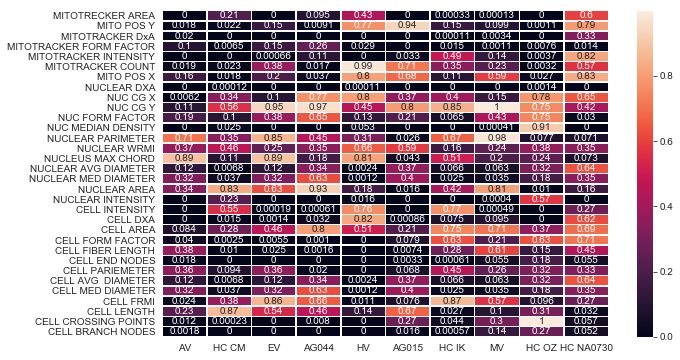

In [99]:
fig, ax = plt.subplots(figsize=(10,6)) 
sns.heatmap(data_comp_ks, linewidths=0.5, ax=ax, annot=True)

There is no row without black this means we cannot say the data came from the same distributions.  
Maybe a multiple comparison adjustment will help but I am not sure it fits here.  
Probably more data would had helped.  
Maybe alignment of the data would help?